<a href="https://colab.research.google.com/github/Angellangell/fruit_classifiaction/blob/main/Fruits_Classification_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/moltean/fruits'
od.download(dataset_url)

100%|██████████| 1.28G/1.28G [00:26<00:00, 52.0MB/s]


I needed to upload kaggle.json file, so as to be able to load the dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from torch.utils.data import random_split, Subset, DataLoader
from tqdm import tqdm
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import functional as F

In [ ]:
from torch.utils.data import Subset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms


# Define paths and parameters
data_dir = 'fruits/fruits-360_dataset/fruits-360'
batch_size = 32
num_workers = 2

# Define transformations including data augmentation
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_val_test = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define paths for train, validation, and test datasets
train_dir = data_dir + '/Training'

test_dir = data_dir + '/Test'

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform_train)
##val_dataset = ImageFolder(root=val_dir, transform=transform_val_test)
test_dataset = ImageFolder(root=test_dir, transform=transform_val_test)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
#val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)


In [ ]:
# Define transformations including data augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(100),  # Randomly crop the image and resize it to 100x100
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=131):  # Assuming you have 131 classes in your dataset
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 12 * 12, 512)  # Adjust input size based on your image dimensions
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Adding dropout for regularization

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 12 * 12)  # Adjust this based on your image dimensions after convolution and pooling
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize the model
model = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

# Function to perform training
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, early_stopping_rounds=None, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            total_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = total_correct / total_samples

        print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Early stopping
        if early_stopping_rounds:
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'Early stopping after epoch {epoch+1}')
                break

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=20, early_stopping_rounds=True, patience=5)

Train Loss: 0.7211, Accuracy: 0.7961


Train Loss: 0.1475, Accuracy: 0.9516


Train Loss: 0.0974, Accuracy: 0.9688


Train Loss: 0.0783, Accuracy: 0.9755


Train Loss: 0.0670, Accuracy: 0.9792


Train Loss: 0.0544, Accuracy: 0.9833


Train Loss: 0.0472, Accuracy: 0.9859


Train Loss: 0.0480, Accuracy: 0.9859


Train Loss: 0.0417, Accuracy: 0.9879


Train Loss: 0.0412, Accuracy: 0.9886


Train Loss: 0.0372, Accuracy: 0.9891


Train Loss: 0.0367, Accuracy: 0.9899


Train Loss: 0.0348, Accuracy: 0.9902


Train Loss: 0.0344, Accuracy: 0.9908


Train Loss: 0.0294, Accuracy: 0.9922


Train Loss: 0.0338, Accuracy: 0.9915


Train Loss: 0.0313, Accuracy: 0.9920


Train Loss: 0.0344, Accuracy: 0.9924


Train Loss: 0.0277, Accuracy: 0.9930


Train Loss: 0.0313, Accuracy: 0.9925


In [ ]:
def experiment_hyperparameters(learning_rates, batch_sizes, num_epochs):
    results = []

    for lr in learning_rates:
        for batch_size in batch_sizes:
            for epochs in num_epochs:
                print(f"Training with learning rate: {lr}, batch size: {batch_size}, and epochs: {epochs}")
                # Initialize the model
                model = CNN()

                # Define loss function and optimizer
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                # Train the model
                train_model(model, train_loader, criterion, optimizer, num_epochs=epochs, early_stopping_rounds=True, patience=5)

                # Evaluate the model on the test set
                test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

                # Record results
                results.append({
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'epochs': epochs,
                    'test_loss': test_loss,
                    'test_accuracy': test_accuracy
                })

    return results

def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            total_loss += loss.item() * inputs.size(0)
            total_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate overall loss and accuracy
    overall_loss = total_loss / len(dataloader.dataset)
    overall_accuracy = total_correct / total_samples

    print(f'Test Loss: {overall_loss:.4f}, Accuracy: {overall_accuracy:.4f}')

    return overall_loss, overall_accuracy

# Define hyperparameters to experiment with
learning_rates = [0.001, 0.0005]
batch_sizes = [16, 32]
num_epochs = [10, 15]

# Perform experiments
results = experiment_hyperparameters(learning_rates, batch_sizes, num_epochs)

# Print results
for result in results:
    print(f"Learning Rate: {result['learning_rate']}, Batch Size: {result['batch_size']}, Epochs: {result['epochs']}, Test Loss: {result['test_loss']}, Test Accuracy: {result['test_accuracy']}")

Training with learning rate: 0.001, batch size: 16, and epochs: 10


Train Loss: 0.7777, Accuracy: 0.7759


Train Loss: 0.1643, Accuracy: 0.9454


Train Loss: 0.1056, Accuracy: 0.9650


Train Loss: 0.0814, Accuracy: 0.9739


Train Loss: 0.0709, Accuracy: 0.9781


Train Loss: 0.0593, Accuracy: 0.9816


Train Loss: 0.0528, Accuracy: 0.9839


Train Loss: 0.0495, Accuracy: 0.9852


Train Loss: 0.0481, Accuracy: 0.9862


Train Loss: 0.0385, Accuracy: 0.9883


Test Loss: 0.1724, Accuracy: 0.9769
Training with learning rate: 0.001, batch size: 16, and epochs: 15


Train Loss: 0.7378, Accuracy: 0.7873


Train Loss: 0.1614, Accuracy: 0.9459


Train Loss: 0.1053, Accuracy: 0.9657


Train Loss: 0.0883, Accuracy: 0.9723


Train Loss: 0.0688, Accuracy: 0.9787


Train Loss: 0.0630, Accuracy: 0.9808


Train Loss: 0.0559, Accuracy: 0.9826


Train Loss: 0.0476, Accuracy: 0.9859


Train Loss: 0.0453, Accuracy: 0.9863


Train Loss: 0.0387, Accuracy: 0.9890


Train Loss: 0.0390, Accuracy: 0.9893


Train Loss: 0.0408, Accuracy: 0.9889


Train Loss: 0.0403, Accuracy: 0.9896


Train Loss: 0.0315, Accuracy: 0.9915


Train Loss: 0.0331, Accuracy: 0.9914


Test Loss: 0.1732, Accuracy: 0.9746
Training with learning rate: 0.001, batch size: 32, and epochs: 10


Train Loss: 0.9923, Accuracy: 0.7217


Train Loss: 0.1911, Accuracy: 0.9358


Train Loss: 0.1290, Accuracy: 0.9575


Train Loss: 0.0967, Accuracy: 0.9688


Train Loss: 0.0850, Accuracy: 0.9731


Train Loss: 0.0710, Accuracy: 0.9775


Train Loss: 0.0651, Accuracy: 0.9798


Train Loss: 0.0575, Accuracy: 0.9823


Train Loss: 0.0549, Accuracy: 0.9839


Train Loss: 0.0484, Accuracy: 0.9857


Test Loss: 0.1362, Accuracy: 0.9762
Training with learning rate: 0.001, batch size: 32, and epochs: 15


Train Loss: 0.7875, Accuracy: 0.7733


Train Loss: 0.1442, Accuracy: 0.9523


Train Loss: 0.0985, Accuracy: 0.9684


Train Loss: 0.0788, Accuracy: 0.9748


Train Loss: 0.0629, Accuracy: 0.9808


Train Loss: 0.0627, Accuracy: 0.9808


Train Loss: 0.0475, Accuracy: 0.9855


Train Loss: 0.0519, Accuracy: 0.9850


Train Loss: 0.0417, Accuracy: 0.9871


Train Loss: 0.0451, Accuracy: 0.9874


Train Loss: 0.0394, Accuracy: 0.9888


Train Loss: 0.0357, Accuracy: 0.9899


Train Loss: 0.0358, Accuracy: 0.9907


Train Loss: 0.0408, Accuracy: 0.9895


Train Loss: 0.0323, Accuracy: 0.9921


Test Loss: 0.2398, Accuracy: 0.9736
Training with learning rate: 0.0005, batch size: 16, and epochs: 10


Train Loss: 0.7768, Accuracy: 0.7802


Train Loss: 0.1342, Accuracy: 0.9553


Train Loss: 0.0871, Accuracy: 0.9707


Train Loss: 0.0610, Accuracy: 0.9797


Train Loss: 0.0536, Accuracy: 0.9831


Train Loss: 0.0471, Accuracy: 0.9848


Train Loss: 0.0386, Accuracy: 0.9873


Train Loss: 0.0349, Accuracy: 0.9894


Train Loss: 0.0284, Accuracy: 0.9909


Train Loss: 0.0307, Accuracy: 0.9907


Test Loss: 0.1145, Accuracy: 0.9825
Training with learning rate: 0.0005, batch size: 16, and epochs: 15


Train Loss: 0.9197, Accuracy: 0.7433


Train Loss: 0.1600, Accuracy: 0.9467


Train Loss: 0.1079, Accuracy: 0.9638


Train Loss: 0.0805, Accuracy: 0.9733


Train Loss: 0.0673, Accuracy: 0.9780


Train Loss: 0.0524, Accuracy: 0.9829


Train Loss: 0.0474, Accuracy: 0.9850


Train Loss: 0.0433, Accuracy: 0.9859


Train Loss: 0.0379, Accuracy: 0.9881


Train Loss: 0.0343, Accuracy: 0.9893


Train Loss: 0.0331, Accuracy: 0.9900


Train Loss: 0.0300, Accuracy: 0.9909


Train Loss: 0.0275, Accuracy: 0.9915


Train Loss: 0.0251, Accuracy: 0.9922


Train Loss: 0.0230, Accuracy: 0.9926


Test Loss: 0.1817, Accuracy: 0.9738
Training with learning rate: 0.0005, batch size: 32, and epochs: 10


Train Loss: 0.8728, Accuracy: 0.7529


Train Loss: 0.1460, Accuracy: 0.9509


Train Loss: 0.0903, Accuracy: 0.9698


Train Loss: 0.0710, Accuracy: 0.9771


Train Loss: 0.0571, Accuracy: 0.9812


Train Loss: 0.0481, Accuracy: 0.9843


Train Loss: 0.0373, Accuracy: 0.9876


Train Loss: 0.0380, Accuracy: 0.9879


Train Loss: 0.0297, Accuracy: 0.9905


Train Loss: 0.0331, Accuracy: 0.9899


Test Loss: 0.1397, Accuracy: 0.9760
Training with learning rate: 0.0005, batch size: 32, and epochs: 15


Train Loss: 0.9691, Accuracy: 0.7311


Train Loss: 0.1567, Accuracy: 0.9476


Train Loss: 0.0992, Accuracy: 0.9663


Train Loss: 0.0759, Accuracy: 0.9746


Train Loss: 0.0602, Accuracy: 0.9797


Train Loss: 0.0514, Accuracy: 0.9831


Train Loss: 0.0474, Accuracy: 0.9845


Train Loss: 0.0387, Accuracy: 0.9871


Train Loss: 0.0360, Accuracy: 0.9883


Train Loss: 0.0319, Accuracy: 0.9900


Train Loss: 0.0299, Accuracy: 0.9904


Train Loss: 0.0264, Accuracy: 0.9920


Train Loss: 0.0264, Accuracy: 0.9918


Train Loss: 0.0224, Accuracy: 0.9930


Train Loss: 0.0225, Accuracy: 0.9932


Test Loss: 0.1446, Accuracy: 0.9804
Learning Rate: 0.001, Batch Size: 16, Epochs: 10, Test Loss: 0.17241410100184912, Test Accuracy: 0.9769481664315938
Learning Rate: 0.001, Batch Size: 16, Epochs: 15, Test Loss: 0.17318855344760536, Test Accuracy: 0.9745680535966149
Learning Rate: 0.001, Batch Size: 32, Epochs: 10, Test Loss: 0.1361818744803871, Test Accuracy: 0.9761547954866009
Learning Rate: 0.001, Batch Size: 32, Epochs: 15, Test Loss: 0.2397533482607887, Test Accuracy: 0.9735543018335684
Learning Rate: 0.0005, Batch Size: 16, Epochs: 10, Test Loss: 0.11446730724658788, Test Accuracy: 0.9825017630465445
Learning Rate: 0.0005, Batch Size: 16, Epochs: 15, Test Loss: 0.18172628726030504, Test Accuracy: 0.973774682651622
Learning Rate: 0.0005, Batch Size: 32, Epochs: 10, Test Loss: 0.13974904753659995, Test Accuracy: 0.9759784908321579
Learning Rate: 0.0005, Batch Size: 32, Epochs: 15, Test Loss: 0.1445947163636463, Test Accuracy: 0.9804301833568406


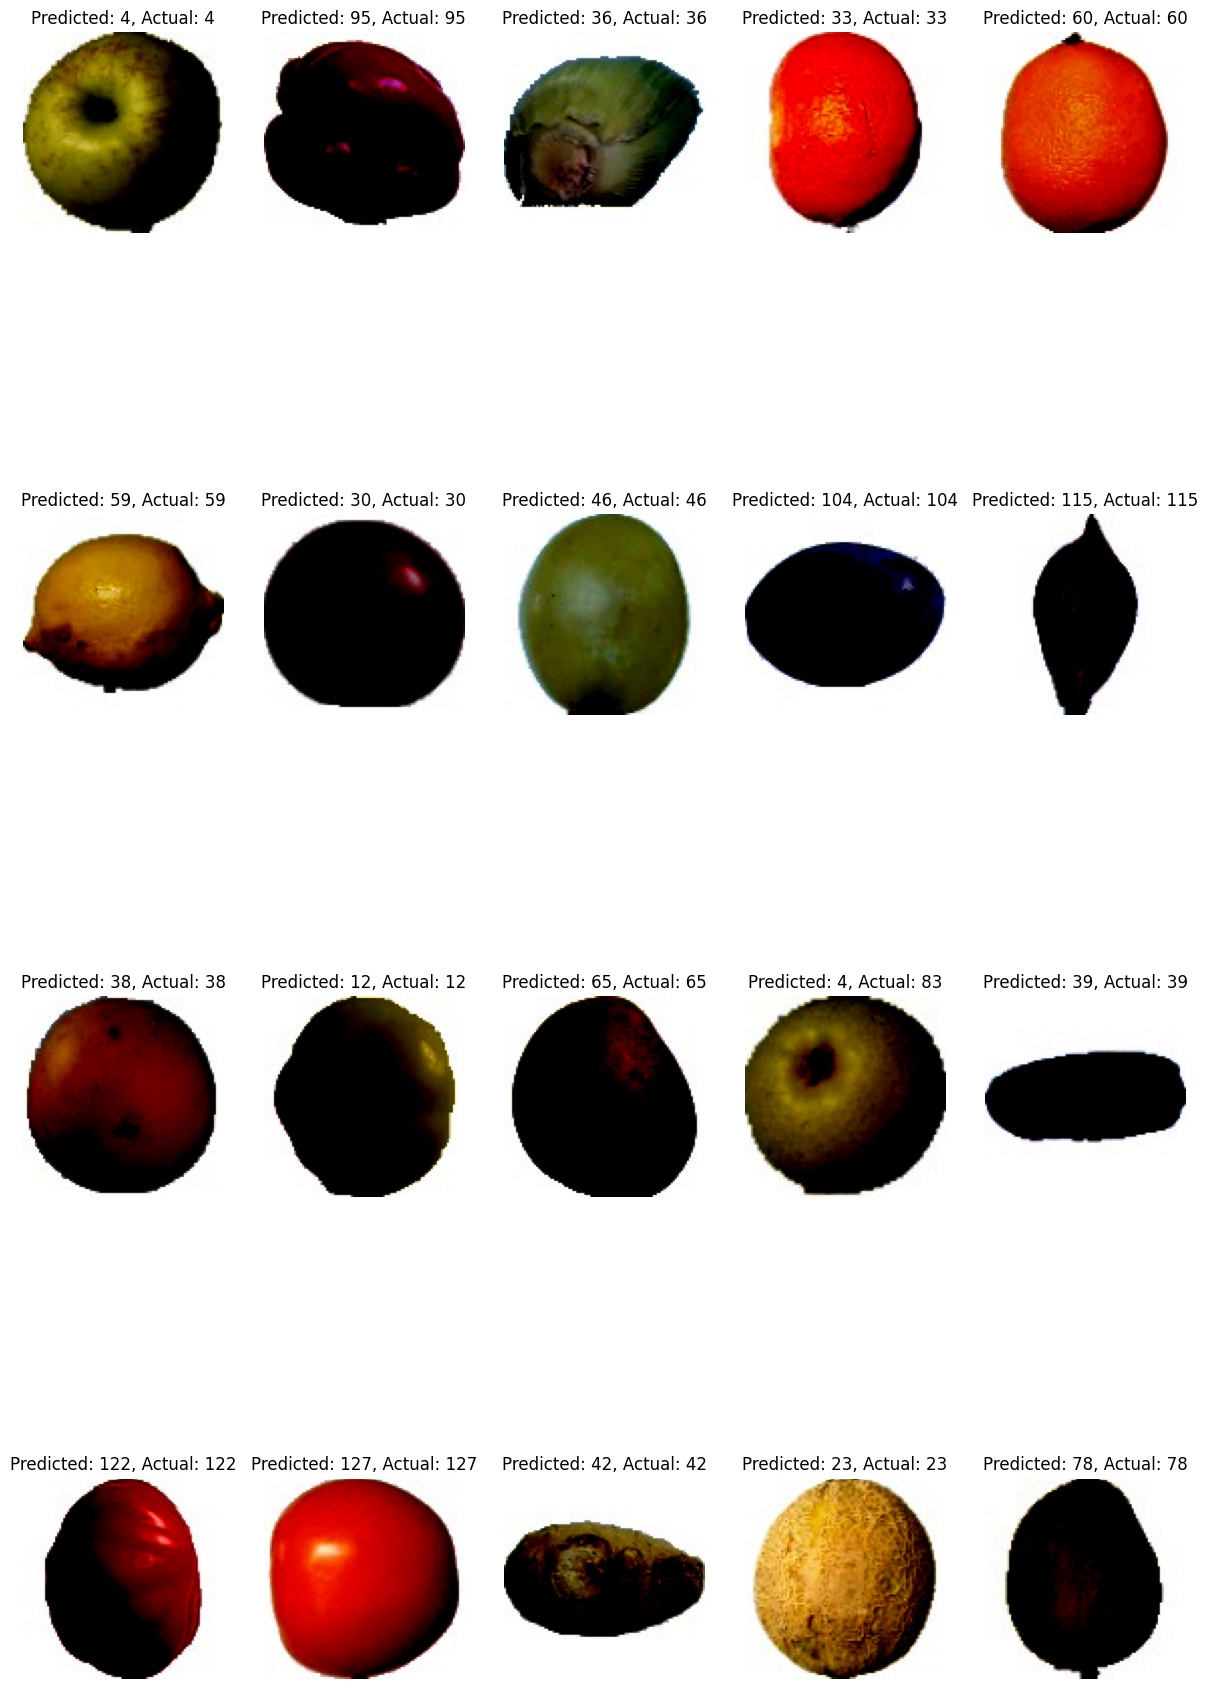

In [ ]:
# Create data loaders with shuffle enabled
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Function to visualize predictions and misclassifications on the test set in rows and columns
def visualize_predictions_test(model, dataloader, num_images_per_row=5, num_rows=4):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    images_so_far = 0
    fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, 6*num_rows))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                ax = axs[images_so_far // num_images_per_row, images_so_far % num_images_per_row]
                ax.axis('off')
                ax.set_title(f'Predicted: {preds[j]}, Actual: {labels[j]}')
                ax.imshow(inputs.cpu().data[j].permute(1, 2, 0))  # Transpose image dimensions from (C, H, W) to (H, W, C)

                images_so_far += 1
                if images_so_far >= num_images_per_row * num_rows:
                    model.train()
                    return

    # Hide empty subplots
    for ax in axs.ravel():
        if not ax.images:
            ax.axis('off')

# Visualize predictions and misclassifications on the test set in rows and columns
visualize_predictions_test(model, test_loader, num_images_per_row=5, num_rows=4)

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            total_loss += loss.item() * inputs.size(0)
            total_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate overall loss and accuracy
    overall_loss = total_loss / len(dataloader.dataset)
    overall_accuracy = total_correct / total_samples

    print(f'Test Loss: {overall_loss:.4f}, Accuracy: {overall_accuracy:.4f}')

    return overall_loss, overall_accuracy

Train Loss: 0.0764, Accuracy: 0.9752


Train Loss: 0.0617, Accuracy: 0.9806


Train Loss: 0.0538, Accuracy: 0.9826


Train Loss: 0.0471, Accuracy: 0.9860


Train Loss: 0.0414, Accuracy: 0.9874


Train Loss: 0.0428, Accuracy: 0.9880


Train Loss: 0.0364, Accuracy: 0.9895


Train Loss: 0.0390, Accuracy: 0.9892


Train Loss: 0.0338, Accuracy: 0.9914


Train Loss: 0.0313, Accuracy: 0.9913


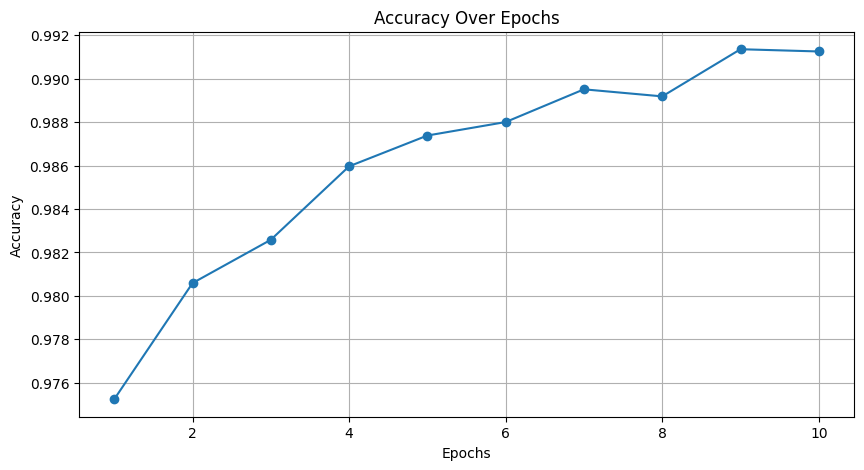

In [ ]:
def visualize_accuracy(accuracy_history):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', linestyle='-')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

# Function to perform training
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, early_stopping_rounds=None, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_loss = float('inf')
    patience_counter = 0
    accuracy_history = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            total_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = total_correct / total_samples
        accuracy_history.append(epoch_accuracy)

        print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Early stopping
        if early_stopping_rounds:
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'Early stopping after epoch {epoch+1}')
                break

    # Visualize accuracy
    visualize_accuracy(accuracy_history)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10, early_stopping_rounds=True, patience=5)
